In [1]:
import pickle
import clip
import socket
import numpy as np
import torch

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


# set device (for number crunching)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [3]:
standalone_model = pickle.load(open("/mnt/data/patrick.koller/masterthesis/data/results/standalone_biased/standalone_resnet50_biased.mdl", 'rb'))
standalone_model.cuda().eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# make sure that all standalone resnet50 parameters are floating point variables (paranoia)
for p in standalone_model.parameters(): 
    p.data = p.data.float() 

In [5]:
# generate list of conv layers
standalone_layers = []
for name, layer in standalone_model.named_modules():
    if "conv" in name:
        standalone_layers.append(name)
        
print(f"Number of layers: {len(standalone_layers)}")

standalone_layers

Number of layers: 49


['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.1.conv3',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer1.2.conv3',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.conv3',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.1.conv3',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.2.conv3',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer2.3.conv3',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.conv3',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.1.conv3',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.2.conv3',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.3.conv3',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.4.conv3',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer3.5.conv3',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.conv3',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.1.conv3',
 'layer4.2.conv1',
 'layer4.2.conv2',
 'layer4.2.conv3']

# load CLIP model

In [6]:
clip_model, clip_preprocess = clip.load("RN50")
clip_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [7]:
# number of feature maps in specific layer
clip_model.visual.layer1[0].conv1.out_channels
# clip_model.visual.layer1[0].conv1.kernel_size

64

In [8]:
# make sure that all clip parameters are floating point variables (paranoia)
for p in clip_model.parameters(): 
    p.data = p.data.float() 

In [9]:
# save layers to be swapped
clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']
    
print(f"Number of layers: {len(clip_layers)}")
clip_layers

Number of layers: 3


['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']

# load dataset

In [10]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 10
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

DATA_DIR='/home/patrick.koller/masterthesis/mnt_data/data'

MNIST dataset already exists
Number of training samples: 2000


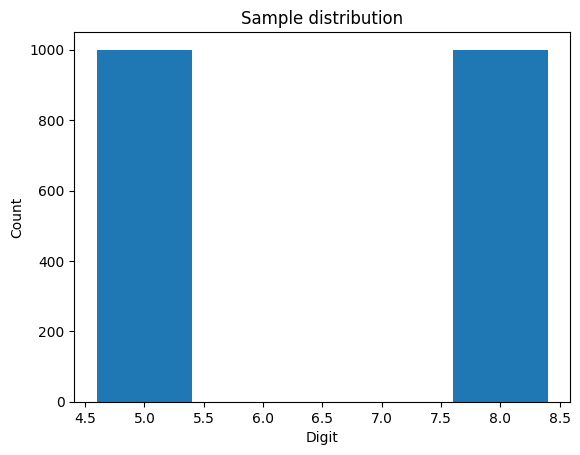

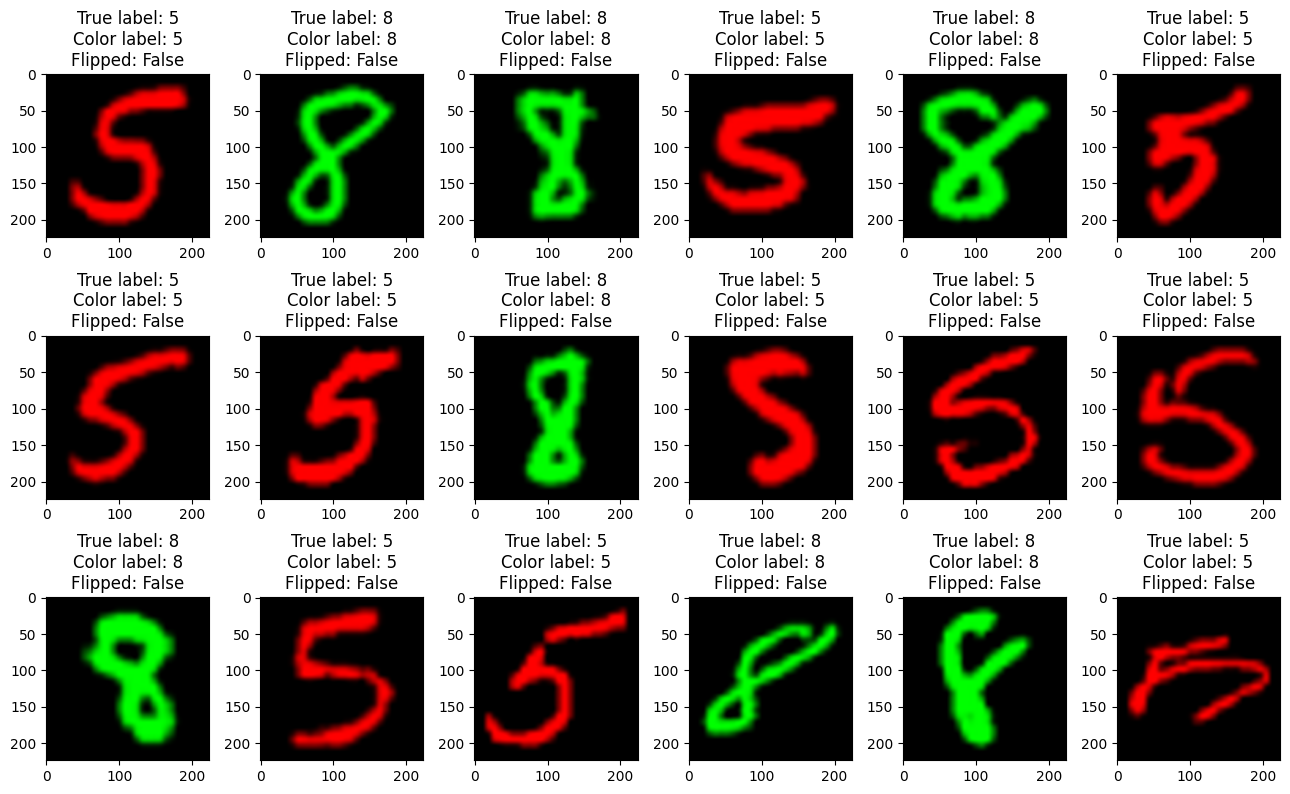

In [11]:
from torchvision import transforms

# initialize dataset
data_set = DatasetMNIST(root=DATA_DIR,
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=clip_preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print(f"Number of training samples: {len(data_loader.dataset.data_label_tuples)}")
digit_distribution(data_set)
plot_digits(data_set, clip_preprocess)

In [13]:
# sanity check: Use batchsize, such that the number of samples in the dataset is divisible by the batchsize. This avoids complicated handling for the last batch.
if (len(data_loader.dataset.data_label_tuples) % DATASET_BATCH_SIZE != 0):
    raise Exception(f"Number of samples in dataset (={len(data_loader.dataset.data_label_tuples)}) is not divisible by the batch size (={DATASET_BATCH_SIZE})! Correct it to make life easier!")

# check gaussians

In [14]:
from torchvision import transforms

# model1 = standalone
# model2 = clip
def compute_activations(model1, model1_layers, model2, model2_layers, dataloader, device):
        
    model1_stats_list = []
    model2_stats_list = []
    
    # do not keep track of gradients
    with torch.no_grad():
        
        # batch processing
        for iteration, data in enumerate(dataloader):
            
            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            ###############################################################################
            # Compute activations for model 1
            ###############################################################################
            # inference first model
            _ = model1(inputs)

            # store activations from current batch
            model1_activations = {}
            for layer in model1_layers:
                model1_activations[layer] = []    
                model1_activation = model1.retained_layer(layer, clear = True)
                model1_activations[layer].append(model1_activation)
            
            ###############################################################################
            # Compute activations for model 2
            ###############################################################################
            # preprocess images
            transform = transforms.ToPILImage()
            images_new = []
            for img in inputs:
                images_new.append(clip_preprocess(transform(img)))

            # building image features
            images = torch.tensor(np.stack(images_new)).cuda()
            
            # inference second model
            _ = model2.model.encode_image(images)

            # store activations from current batch
            model2_activations = {}
            for layer in model2_layers:
                model2_activations[layer] = []    
                model2_activation = model2.retained_layer(layer, clear = True)
                model2_activations[layer].append(model2_activation)

    return model1_activations, model2_activations

In [15]:
def save_array(array, filename):
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [16]:
from utils import matching, nethook, stats

standalone_model.eval()
clip_model.eval()

# hook layers for model 1
standalone_model = nethook.InstrumentedModel(standalone_model)
standalone_model.retain_layers(standalone_layers)

# hook layers for model 2
clip_model = nethook.InstrumentedModel(clip_model)
clip_model.retain_layers(clip_layers)

# compute dataset statistics
standalone_model_activations, clip_model_activations = compute_activations(standalone_model, standalone_layers, clip_model, clip_layers, data_loader, device)


Batch 0 is being processed...
Batch 1 is being processed...
Batch 2 is being processed...
Batch 3 is being processed...
Batch 4 is being processed...
Batch 5 is being processed...
Batch 6 is being processed...
Batch 7 is being processed...
Batch 8 is being processed...
Batch 9 is being processed...
Batch 10 is being processed...
Batch 11 is being processed...
Batch 12 is being processed...
Batch 13 is being processed...
Batch 14 is being processed...
Batch 15 is being processed...
Batch 16 is being processed...
Batch 17 is being processed...
Batch 18 is being processed...
Batch 19 is being processed...
Batch 20 is being processed...
Batch 21 is being processed...
Batch 22 is being processed...
Batch 23 is being processed...
Batch 24 is being processed...
Batch 25 is being processed...
Batch 26 is being processed...
Batch 27 is being processed...
Batch 28 is being processed...
Batch 29 is being processed...
Batch 30 is being processed...
Batch 31 is being processed...
Batch 32 is being 

In [23]:
standalone_model_activations.keys()

dict_keys(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3'])

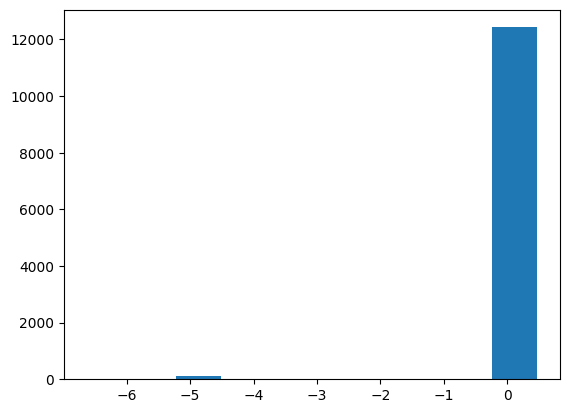

In [47]:
plt.hist((standalone_model_activations['conv1'][0])[:,47,:,:].mean(dim=0).flatten().cpu())
plt.show()